# Why do TV series get cancelled?

>Ervin Madaha, Shuaib Yunus, Jennifer Wilkens

The kind folks at [IMDb](https://www.imdb.com/interfaces/) (owned by Amazon) provide an up-to-date dataset of their extensive movie database for personal and non-commercial use.

We've always wondered by TV series that have a diehard following get cancelled. We figured we could visualize our way to some answers.

We'd like to show you what we found (or didn't?).

Let's import the modules we depend on:

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Genres

Let's see what genres can ~~tell~~ show us!

Load the TSV file containing information about titles:

In [4]:
ratings_dtype = {
    'tconst': str,
    'averageRating': float,
    'numVotes': int
}

ratings = pd.read_csv('./title.ratings.tsv.gz',
                      sep='\t', header=0, dtype=ratings_dtype)

In [266]:
ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.8,1383
1,tt0000002,6.5,162
2,tt0000003,6.6,971
3,tt0000004,6.4,98
4,tt0000005,6.2,1663


Load TSV file containing IMDb rating and votes information for titles:

In [267]:
title_dtype = {
    'tconst': str,
    'titleType': str,
    'primaryTitle': str,
    'originalTitle': str,
    'isAdult': int,
    'startYear': str,
    'endYear': str,
    'runtimeMinutes': object,
    'genres': str
}

title = pd.read_csv('./title.basics.tsv.gz',
                    sep='\t', header=0, dtype=title_dtype)

In [268]:
title.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,\N,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,Short


What are the types of titles?

In [269]:
title['titleType'].unique()

array(['short', 'movie', 'tvMovie', 'tvSeries', 'tvEpisode', 'tvShort',
       'tvMiniSeries', 'tvSpecial', 'video', 'videoGame'], dtype=object)

Create a data frame containing only TV series:

In [270]:
series = title[title['titleType'] == 'tvSeries']
series.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
34995,tt0035599,tvSeries,Voice of Firestone Televues,Voice of Firestone Televues,0,1943,1947,15,\N
37626,tt0038276,tvSeries,You Are an Artist,You Are an Artist,0,1946,1950,15,\N
38460,tt0039120,tvSeries,Americana,Americana,0,1947,1949,30,"Family,Game-Show"
38461,tt0039121,tvSeries,Birthday Party,Birthday Party,0,1947,1949,30,Family
38462,tt0039122,tvSeries,The Borden Show,The Borden Show,0,1947,\N,30,"Comedy,Music"


What are the genres a TV series could belong to?

In [271]:
genres_with_dupes = series['genres'].map(lambda x: [] if x == '\\N' else x.split(','))
genres_with_dupes_list = [y for x in genres_with_dupes for y in x]
genres = list(set(genres_with_dupes_list))
genres

['Animation',
 'Documentary',
 'Western',
 'Thriller',
 'Game-Show',
 'Family',
 'News',
 'Drama',
 'Mystery',
 'Fantasy',
 'Action',
 'Adventure',
 'Reality-TV',
 'Horror',
 'Sport',
 'Music',
 'Romance',
 'Biography',
 'Crime',
 'War',
 'Talk-Show',
 'History',
 'Musical',
 'Sci-Fi',
 'Adult',
 'Short',
 'Comedy']

Set genres column in series dataframe to array of genres:

In [272]:
# To get rid of SettingWithCopyWarning. See https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
series.is_copy = False

series['genres'] = genres_with_dupes
series.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
34995,tt0035599,tvSeries,Voice of Firestone Televues,Voice of Firestone Televues,0,1943,1947,15,[]
37626,tt0038276,tvSeries,You Are an Artist,You Are an Artist,0,1946,1950,15,[]
38460,tt0039120,tvSeries,Americana,Americana,0,1947,1949,30,"[Family, Game-Show]"
38461,tt0039121,tvSeries,Birthday Party,Birthday Party,0,1947,1949,30,[Family]
38462,tt0039122,tvSeries,The Borden Show,The Borden Show,0,1947,\N,30,"[Comedy, Music]"


### How many TV series have ever been released in each genre?

In [273]:
genre_ratios = pd.Series(genres_with_dupes_list).value_counts()
top_10_genres = genre_ratios[:10].index.values
# Flip values
# genre_ratios = pd.Series(genre_ratios.index.values, index=genre_ratios)

# Pair each genre among the top 10 with a color.
hexs = ["#96ceb4", "#ffcc5c", "#f9d5e5", "#d9ad7c", "#87bdd8",
          "#937860", "#7a3b2e", "#c1502e", "#ff6f69", "#ffeead"]

colors = {}
for g, c in zip(top_10_genres, hexs):
  colors[g] = c

genre_ratios.head()

Comedy         36302
Drama          23299
Documentary    16715
Reality-TV     13859
Talk-Show      11077
dtype: int64

In [274]:
def plot_count_per_genre():
    sns.set_style("whitegrid", {'axes.grid' : False})
    d = pd.DataFrame(data={'genre': genres_with_dupes_list})
    ax = sns.countplot(y='genre', data=d, palette='Set2', order=d['genre'].value_counts().index)
    plt.title('Total numbers of series produced across all genres')

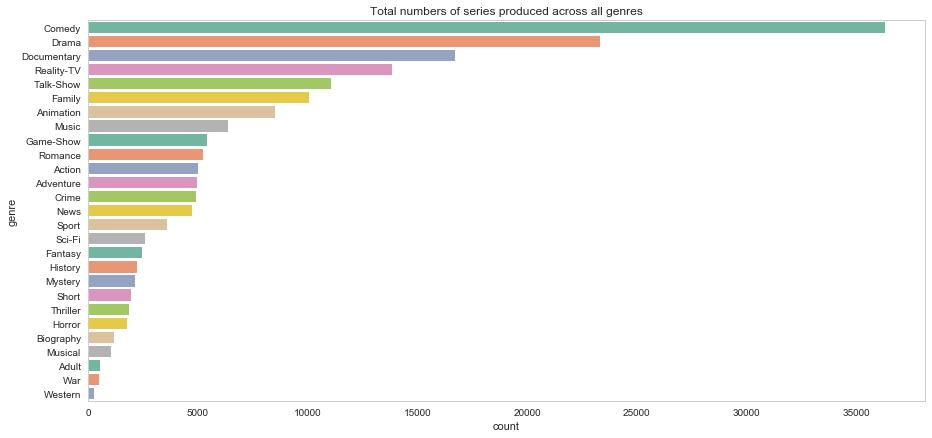

In [275]:
plot_count_per_genre()

### How have the numbers of series produced in each genre changed over the years?

What range of years do we have data for?

In [276]:
start_years = [i for i in title['startYear'].unique() if i != '\\N']
n = list(map(int, start_years))
min(n), max(n)

(1874, 2115)

We want the numbers of TV series released within each genre every year.

In [277]:
def count_genres(year):
  matches = series.loc[series['startYear'] == year]
  gs = [y for x in matches['genres'] for y in x if y != '\\N']
  return {x: gs.count(x) for x in gs}

genres_by_year = []
for yr in start_years:
  gc = count_genres(yr)
  if bool(gc): genres_by_year.append((yr,gc))
        
genres_by_year[1:5]

[('1910', {'News': 1}),
 ('1916', {'Talk-Show': 1}),
 ('1936', {'Comedy': 3, 'Family': 1, 'Music': 3, 'Sport': 1, 'Talk-Show': 1}),
 ('1922', {'News': 1})]

In [278]:
sns.set_style("whitegrid", {'axes.grid' : False})

def create_genre_df(genre):
  gs = []
  for j in genres_by_year:
    if genre in j[1] and int(j[0]) > 1980 and int(j[0]) < 2018:
      gs.append((j[0], j[1][genre]))

  sorted(gs, key=lambda x: int(x[0]))

  xs, ys = zip(*gs)

  df = pd.DataFrame({'Years': pd.Series(xs), genre: pd.Series(ys)})
  df['Years'] = pd.to_datetime(df['Years'])
  df = df.sort_values(by='Years')

  return df

def plot_num_of_series():
    dfs = [(genre, create_genre_df(genre)) for genre in top_10_genres]

    fig = plt.figure()

    for genre, frame in dfs:
        plt.plot(frame['Years'], frame[genre], color = colors[genre])

    plt.legend()
    plt.title('Numbers of series produced over the years for the top 10 genres')
    plt.show()

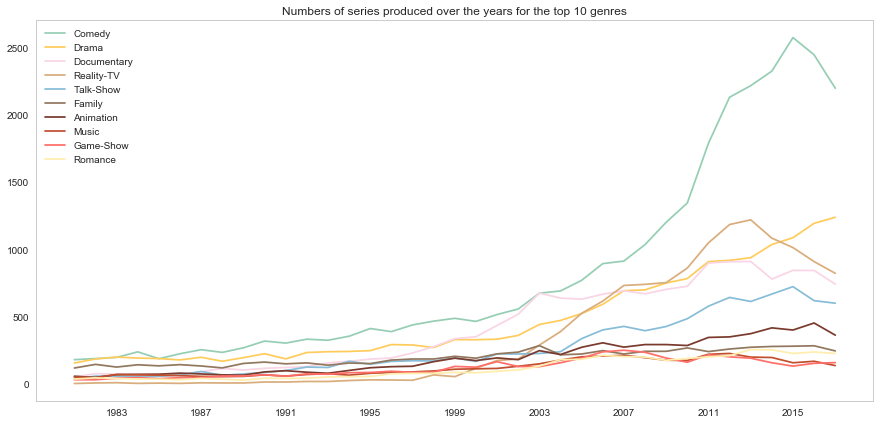

In [279]:
plot_num_of_series()

### What are the percentages of TV Genres over the years?

Create data frame of genres in long form:

In [280]:
df1 = series[['startYear', 'genres']].dropna(subset=['startYear'])
df1 = df1[df1['startYear'] != '\\N']
pd.to_numeric(df1['startYear'])
df1 = pd.DataFrame(df1['genres'].tolist(), index=df1['startYear']).stack().reset_index(name='genres')[['genres','startYear']]
df1.tail()

,genres,startYear
174041,Talk-Show,2018
174042,Documentary,2018
174043,Sci-Fi,2019
174044,Adult,2005
174045,Crime,2018


In [281]:
def plot_genres_percents(df):
    sns.set_style('whitegrid', {'axes.grid' : False})
    df['startYear'] = pd.to_numeric(df['startYear'])
    df = df[df['startYear'] > 1989]
    df = df[df['startYear'] < 2018]
    df = df[df['genres'].isin(top_10_genres)]

    props = lambda key: {'color': colors[key[1]]}
    ax, _ = mosaic(df.sort_values('startYear'), ['startYear', 'genres'], label_rotation=(90,0),
                   labelizer=(lambda _: ''), properties=props, title='Percentages of series made in each genre')

    plt.show()

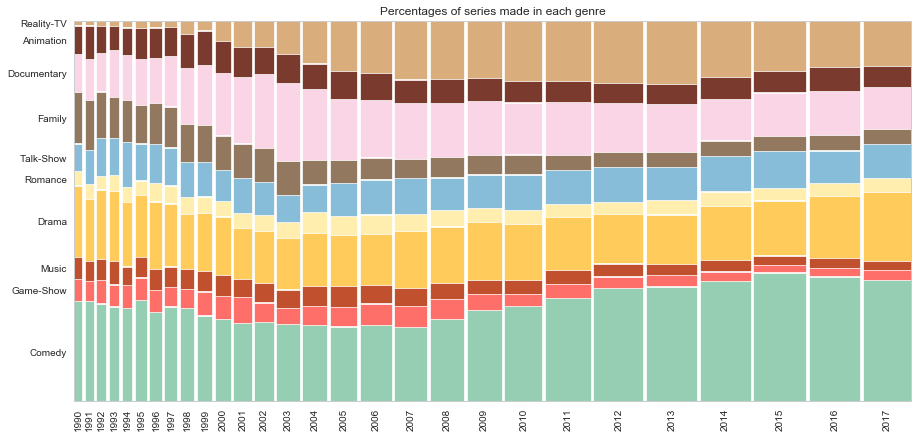

In [282]:
plot_genres_percents(df1)

## Running Years of TV Series

Figure out the series that we know ran to completion and their durations:

In [283]:
df = series[series['startYear'] != '\\N']
df = df[df['endYear'] != '\\N']
df = df.dropna(subset=['startYear', 'endYear', 'primaryTitle'], how='any')
df['runningYears'] = pd.to_numeric(df['endYear']) - pd.to_numeric(df['startYear'])
df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,runningYears
34995,tt0035599,tvSeries,Voice of Firestone Televues,Voice of Firestone Televues,0,1943,1947,15,[],4
37626,tt0038276,tvSeries,You Are an Artist,You Are an Artist,0,1946,1950,15,[],4
38460,tt0039120,tvSeries,Americana,Americana,0,1947,1949,30,"[Family, Game-Show]",2
38461,tt0039121,tvSeries,Birthday Party,Birthday Party,0,1947,1949,30,[Family],2
38463,tt0039123,tvSeries,Kraft Theatre,Kraft Television Theatre,0,1947,1958,60,[Drama],11


### What are the average running years of genres?

In [284]:
sns.set_style('darkgrid', {'axes.grid' : True})

def plot_genre_average(df, col_to_avg, x_label, y_label, title, genres):
  vals_to_avg = []

  for g in genres:
    f = df[df.genres.apply(lambda x: g in x)]
    vals_to_avg.append((g, f[col_to_avg].mean()))

    xs, ys = zip(*vals_to_avg)

  d = pd.DataFrame(data={y_label: xs, x_label: ys})
  d = d.sort_values(by=[x_label], ascending=False)

  ax = sns.barplot(y=y_label, x=x_label, data=d)
  ax.set(xlim=(0, 10))
  ax.set_title(title)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

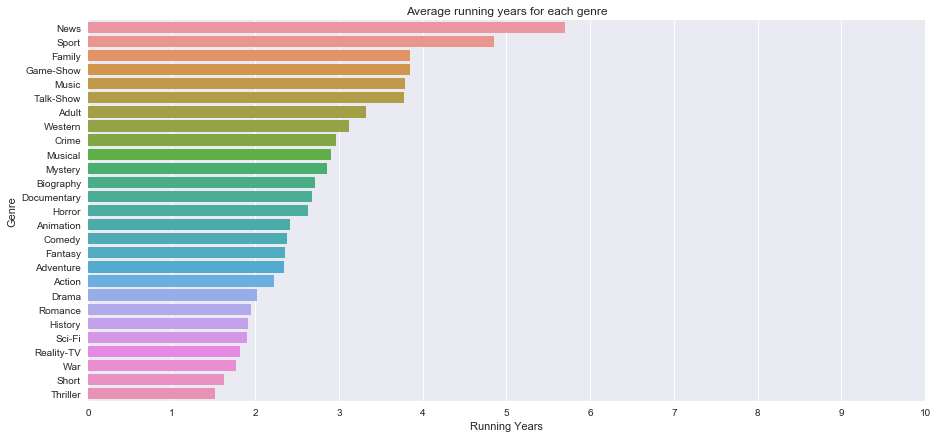

In [285]:
plot_genre_average(df, 'runningYears', 'Running Years', 'Genre', 'Average running years for each genre', genres)

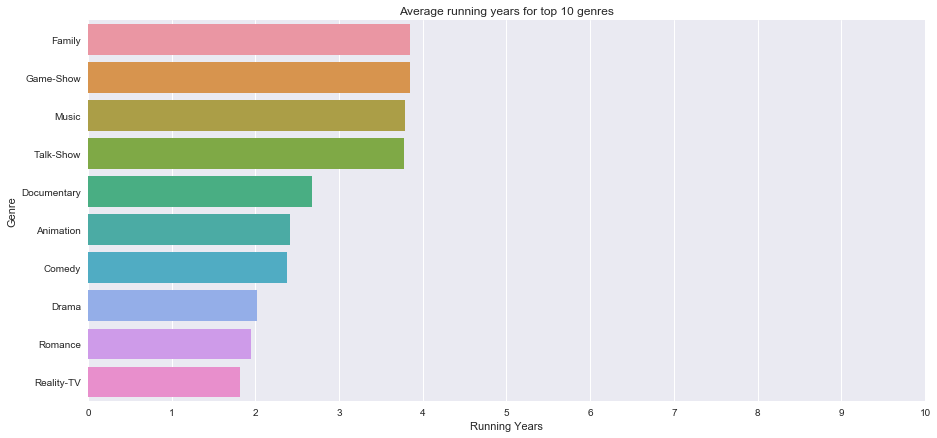

In [286]:
plot_genre_average(df, 'runningYears', 'Running Years', 'Genre', 'Average running years for top 10 genres', top_10_genres)

### What are the average ratings of genres?
First, let's add ratings information to TV series:

In [287]:
series_with_ratings = pd.merge(series, ratings, how='outer', on=['tconst'])
# Drop rows that do not have a genre or rating
series_with_ratings = series_with_ratings.dropna(subset=['genres', 'averageRating'], how='any')
series_with_ratings.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
2,tt0039120,tvSeries,Americana,Americana,0.0,1947,1949,30,"[Family, Game-Show]",3.7,6.0
5,tt0039123,tvSeries,Kraft Theatre,Kraft Television Theatre,0.0,1947,1958,60,[Drama],8.5,108.0
7,tt0039125,tvSeries,Public Prosecutor,Public Prosecutor,0.0,1947,1951,20,"[Crime, Drama, Mystery]",5.9,7.0
8,tt0040021,tvSeries,Actor's Studio,Actor's Studio,0.0,1948,1950,30,[Drama],7.1,48.0
15,tt0040028,tvSeries,Talent Scouts,Talent Scouts,0.0,1948,1958,30,"[Comedy, Family, Music]",6.1,11.0


### Average Genre Ratings

Calculate average ratings for each genre:

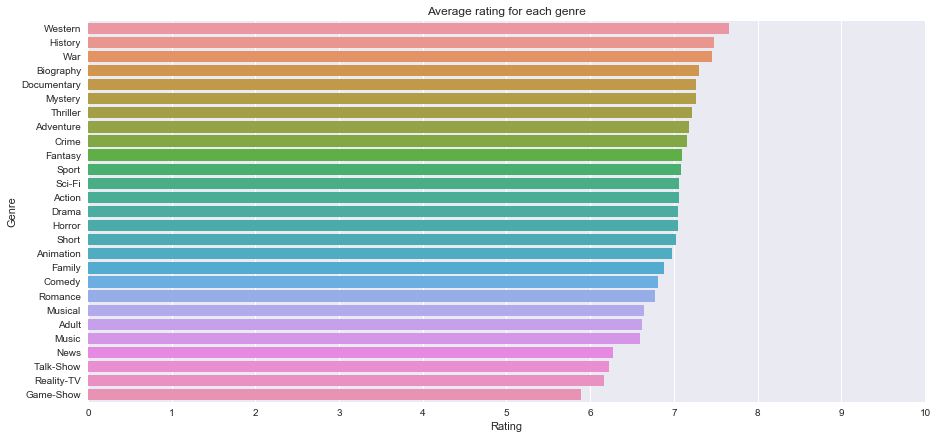

In [288]:
plot_genre_average(series_with_ratings, 'averageRating', 'Rating', 'Genre', 'Average rating for each genre', genres)

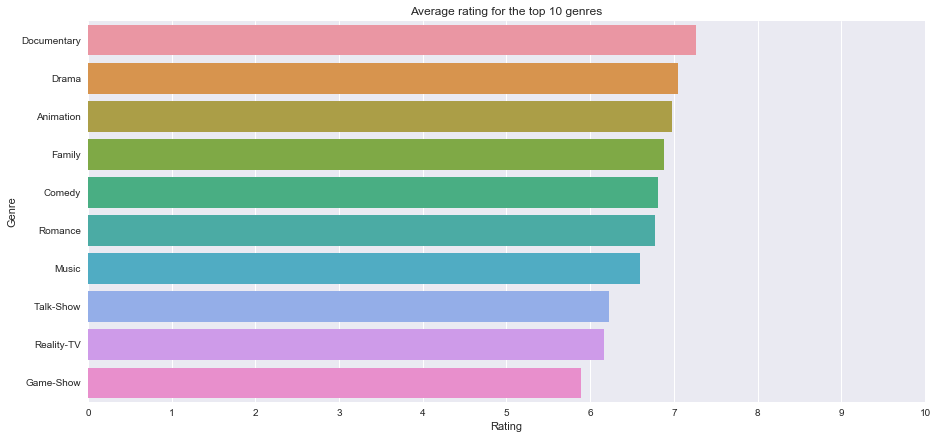

In [289]:
plot_genre_average(series_with_ratings, 'averageRating', 'Rating', 'Genre', 'Average rating for the top 10 genres', top_10_genres)

### What does the distribution of running years for the top 10 genres look like?

Let's create a table containing running years for each genres appearance across all TV series (long form for the `genres` column).

In [290]:
df2 = df[['runningYears', 'genres']].dropna(subset=['runningYears'])
pd.to_numeric(df2['runningYears'])
df2 = pd.DataFrame(df2['genres'].tolist(), index=df2['runningYears']).stack().reset_index(name='genres')[['genres','runningYears']]
df2 = df2[df2['genres'].isin(top_10_genres)]
df2.head()

,genres,runningYears
0,Family,2
1,Game-Show,2
2,Family,2
3,Drama,11
5,Drama,4


In [291]:
def plot_duration_dist(df):
    sns.set_style('whitegrid', {'axes.grid' : True})
    _ = sns.violinplot(x='genres', y='runningYears',
                       data=df).set_title('Distribution of running years for  the top 10 genres')

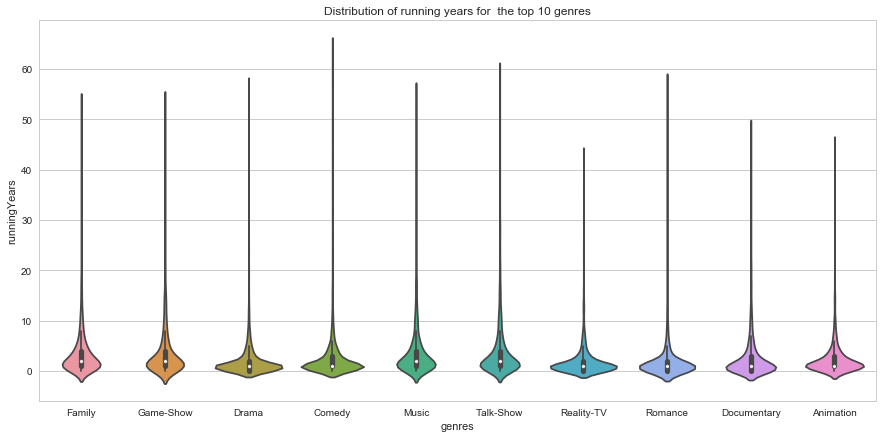

In [292]:
plot_duration_dist(df2)

Let's remove outliers for running years so that our distribution is not heavily skewed. The summary statistics below tells us that the 75% percentile of TV series last 3 years or less. Common knowledge tells us that most TV series don't last for more than 10 seasons, so we can cap the running years at 10 years.

count    35720.000000
mean         2.730795
std          4.444384
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         65.000000
Name: runningYears, dtype: float64

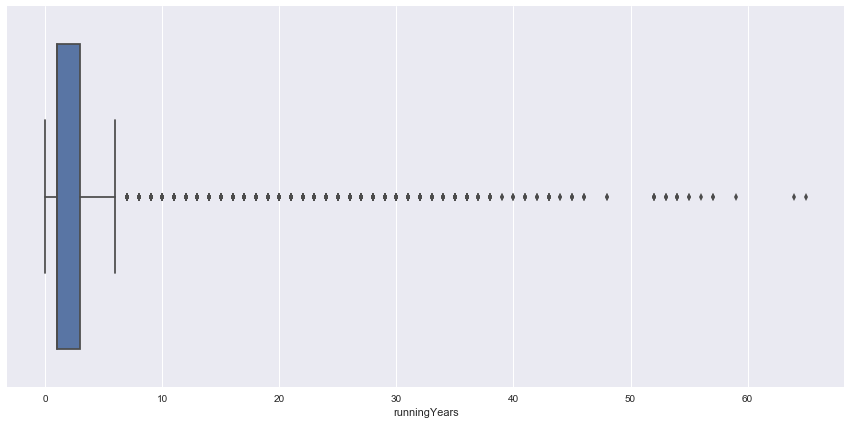

In [293]:
sns.set_style('darkgrid', {'axes.grid' : True})
sns.boxplot(x=df2['runningYears']); df2['runningYears'].describe()

In [294]:
df3 = df2.copy()
df3.loc[df3['runningYears'] > 10,'runningYears'] = 10

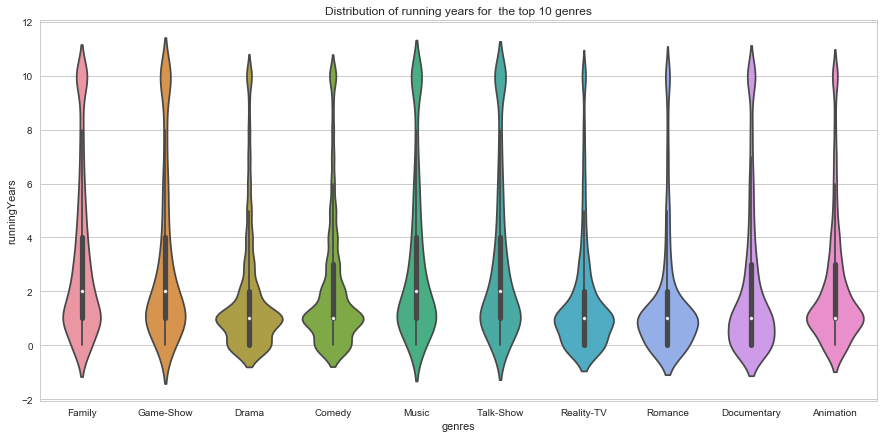

In [295]:
plot_duration_dist(df3)

The violin plot above shows evidence of different distributions of running years for the TV series genres. Let's further explore those differences where the distributions are more dense, which appears to be from 0 to 5 years.

In [296]:
df4 = df2.copy()
df4.loc[df4['runningYears'] > 5,'runningYears'] = 5

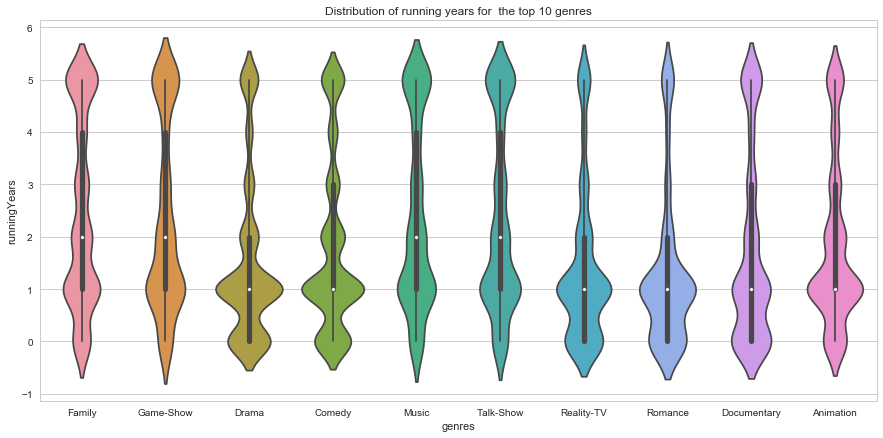

In [297]:
plot_duration_dist(df4)

### What does the distribution of average ratings for the top 10 genres look like?

In [298]:
df5 = series_with_ratings[['averageRating', 'genres']].dropna(subset=['averageRating'])
pd.to_numeric(df5['averageRating'])
df5 = pd.DataFrame(df5['genres'].tolist(), index=df5['averageRating']).stack().reset_index(name='genres')[['genres','averageRating']]
df5 = df5[df5['genres'].isin(top_10_genres)]
df5.head()

,genres,averageRating
0,Family,3.7
1,Game-Show,3.7
2,Drama,8.5
4,Drama,5.9
6,Drama,7.1


In [299]:
def plot_rating_dist(df):
    sns.set_style('whitegrid', {'axes.grid' : True})
    _ = sns.violinplot(x='genres', y='averageRating',
                       data=df).set_title('Distribution of average ratings for  the top 10 genres')

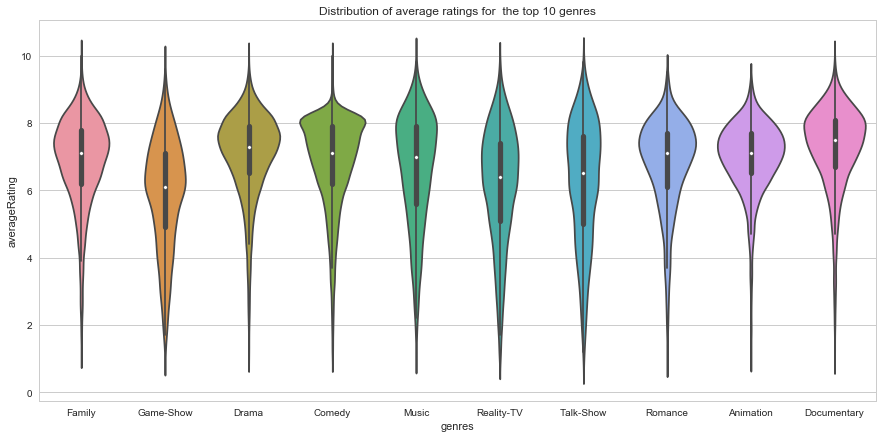

In [300]:
plot_rating_dist(df5)

Let's zoom in to the range where average ratings differ the most, which is from `3` to `9`.

In [301]:
df6 = df5.copy()
df6.loc[df6['averageRating'] < 3,'averageRating'] = 3
df6.loc[df6['averageRating'] > 9,'averageRating'] = 9

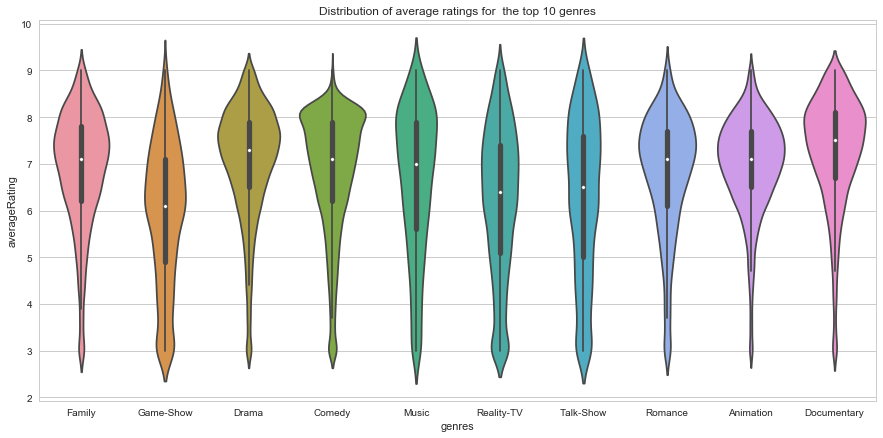

In [302]:
plot_rating_dist(df6)

## Seasons & Episodes 

Now we investigate on how the shows develop at a more granular space.
So let's break it down to each season and episode on how the TV shows tend to diverge.

First let's take a look at raw numbers of the episode dataset

In [303]:
episode_dtype = {
    'tconst': str,
    'parentTconst': str,
    'seasonNumber': str,
    'episodeNumber': str
}

episode = pd.read_csv('./title.episode.tsv.gz',
                    sep='\t', header=0, dtype=episode_dtype)
episode.head()


,tconst,parentTconst,seasonNumber,episodeNumber
0,tt0041951,tt0041038,1,9
1,tt0042816,tt0989125,1,17
2,tt0042889,tt0989125,\N,\N
3,tt0043426,tt0040051,3,42
4,tt0043631,tt0989125,2,16


In [304]:
countEpisodes = episode['tconst'].count()
countAllTitles = title['tconst'].count()
countTVShows = title[title['titleType'] == 'tvSeries']['tconst'].count()
countParentEpisodes = len(episode['parentTconst'].unique())
def printEpisodicNumbers():
    print("All episodes in data : \t\t\t", countEpisodes)
    print("All titles in data : \t\t\t",countAllTitles)
    print("**All TV Shows in episodes :\t\t",countParentEpisodes,"\t\t **from Titles :", countTVShows)
    print("Ratio of all content to TV shows : \t", countEpisodes/countAllTitles)
    print("Average episodes per TV-Series: \t", countEpisodes/countParentEpisodes)

In [305]:
printEpisodicNumbers()

All episodes in data : 			 3429834
All titles in data : 			 5087106
**All TV Shows in episodes :		 108633 		 **from Titles : 148026
Ratio of all content to TV shows : 	 0.6742210600683375
Average episodes per TV-Series: 	 31.57267128773025


Here some mismatch in the imdb data as the number of TV shows in the titles dataset exceed those in the episode dataset almost by ~30%, or rather the lack of episodic information over the rest of the title data could be the cause.

This is important to note as the following part mainly follows the episode dataset and much less of the title dataset (most of the previous section)

In [306]:
seasons = episode.drop_duplicates(['parentTconst','seasonNumber'])
seasons = seasons[seasons['seasonNumber']!='\\N']
seasons['seasonNumber'] = pd.to_numeric(seasons.seasonNumber,errors='coerce')
mySeasons = seasons.drop_duplicates(['parentTconst'],keep='last')
mySeasonsRated = pd.merge(mySeasons, ratings,how='inner',left_on=['parentTconst'],right_on=['tconst'])
counts_seasons = mySeasonsRated['seasonNumber'].value_counts()

myEpisodesRated = pd.merge(episode, ratings,how='inner',left_on=['tconst'],right_on=['tconst'])
myEpisodesRated['seasonNumber'] = pd.to_numeric(myEpisodesRated.seasonNumber,errors='coerce')

A summary of Number of Seasons the TV-shows have had running

In [307]:
counts_seasons.head(15)

1     35707
2      7583
3      3398
4      1735
5      1121
6       730
7       525
8       398
9       334
10      229
11      175
12      136
13      114
15       94
14       83
Name: seasonNumber, dtype: int64

In [308]:
def plot_seriesDistr():
    a = mySeasonsRated['averageRating'].rename('TV-Shows')
    b = myEpisodesRated['averageRating'].rename('episodes')
    b.plot(kind='kde')
    a.plot(kind='kde')
    plt.legend()
    plt.xlim(0,11)
    plt.xlabel("Ratings")
    plt.title("Density Plot of the distribution of Ratings for all TV-Shows")
    plt.show()

Then we can take a look at the general distribution without filtering out any values to see how the Ratings are spread out for the TV-Shows and for the individual episodes.

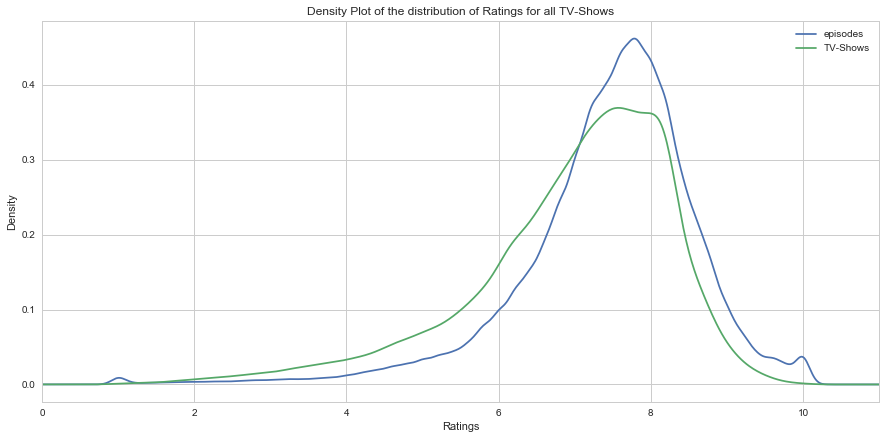

In [309]:
plot_seriesDistr()

'''seasonBins = [*np.array_split(range(1,31), 5)]
x_axis = [str(min(a))+'-'+str(max(a)) for a in seasonBins]
data = pd.DataFrame()
for ix,i in enumerate(seasonBins) :
    data[x_axis[ix]]=mySeasonsRated[mySeasonsRated['seasonNumber'].isin(i)].averageRating
data = data.fillna(data.mean())
def plot_seasonBins():
    ax = sns.boxplot(data=data,notch=True,showfliers=True)
    ax.set(xlabel='seasons', ylabel='ratings',xticks=(x_axis),  title="Ratings accross different seasons")
    plt.show()'''

In [310]:
seasonBins = [*np.array_split(range(1,31), 6)]
x_axis = [str(min(a))+'-'+str(max(a)) for a in seasonBins]
data = [mySeasonsRated[mySeasonsRated['seasonNumber'].isin(i)].averageRating for i in seasonBins ]

def plot_seasonBins(data=data, x_axis=x_axis):
    ax = sns.boxplot(data=data,notch=True,showfliers=True)
    ax.set(xlabel='Seasons', ylabel='Ratings', title = "Ratings spread accross 30 seasons")
    ax.set_xticklabels(x_axis)
    plt.show()

### What happens when a show goes for too long?

Does it fade away slowly until it gets cancelled or does it maintain a high scoring to the very end.

Data here is over TV-show Ratings (i.e. shows with 10+ seasons tend to have a slightly worse rating)

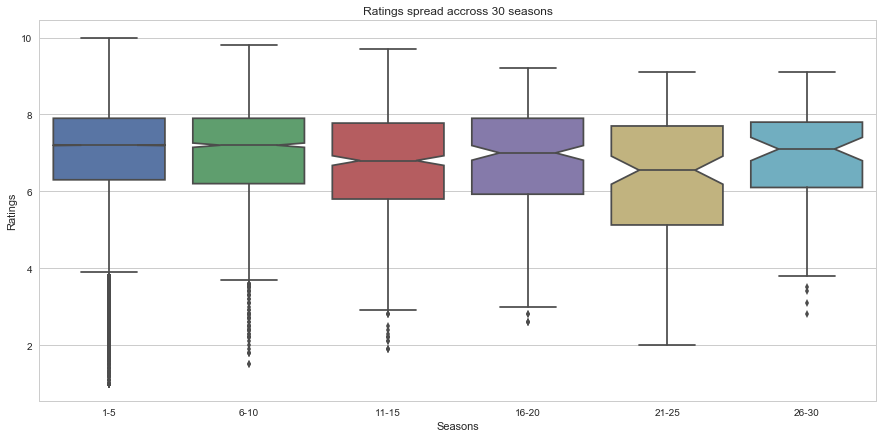

In [311]:
plot_seasonBins()

In [312]:
seasonBins = [*np.array_split(range(1,31), 6)]
x_axis = [str(min(a))+'-'+str(max(a)) for a in seasonBins]
data_epi = [myEpisodesRated[myEpisodesRated['seasonNumber'].isin(i)].averageRating for i in seasonBins ]

Data here is over episode Ratings (i.e. episodes of 10+ seasons tend to perform worse )

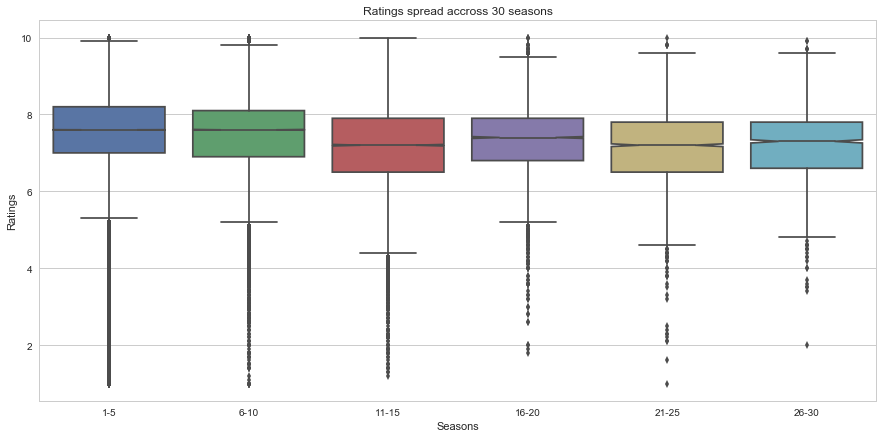

In [313]:
plot_seasonBins(data_epi)

In [314]:
def plot_kdeComparison(data_epi=data_epi):
    data_epi[0].plot(kind='kde', label=x_axis[0])
    data_epi[2].plot(kind='kde', label=x_axis[2])
    plt.xlabel('Average Ratings')
    plt.legend()
    plt.show()

For a more magnified view lets compare the densities of the 1st and 3rd bins

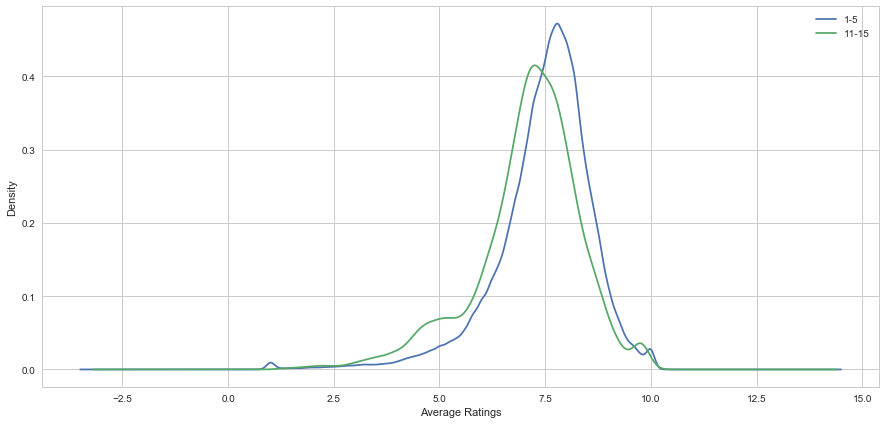

In [315]:
plot_kdeComparison()

In [316]:
def plotFacet(myEpisodesRated=myEpisodesRated):
    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(myEpisodesRated[myEpisodesRated.seasonNumber.isin(range(1,31,5))],row="seasonNumber",hue ='seasonNumber', aspect=15,size=.8, palette=pal)

    g.map(sns.kdeplot, "averageRating", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
    g.map(sns.kdeplot, "averageRating", clip_on=False, color="w", lw=2, bw=.2)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .5, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

    g.map(label, "averageRating")
    g.set_titles("")
    g.set(yticks=[])#, title=" Density of the ratings over different seasons")
    g.fig.subplots_adjust(hspace=-.25)
    g.despine(bottom=True, left=True)

For another interesting perspective we could take a look at how this progresses over each of the bins

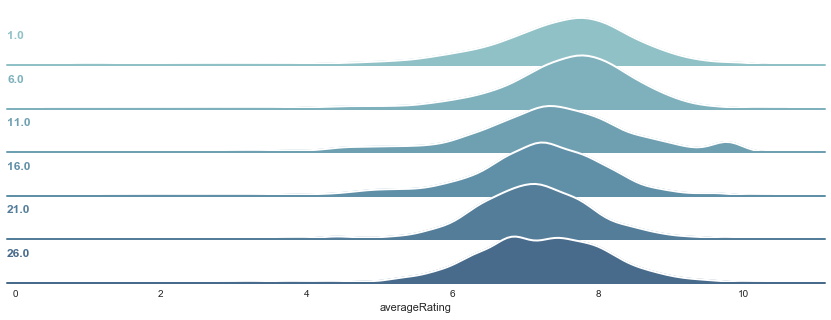

In [317]:
plotFacet()

As for the first 10 seasons they seem to have a very close rating with only some outlier differences.

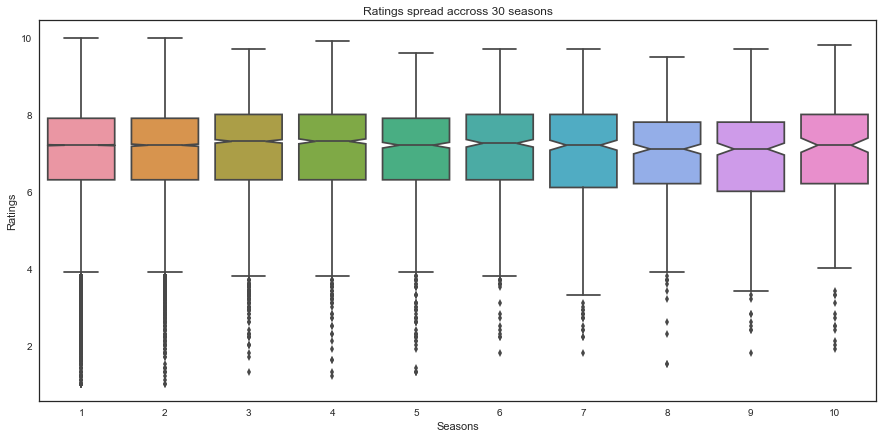

In [318]:
data_epi10 = [mySeasonsRated[mySeasonsRated['seasonNumber']== i].averageRating for i in range(1,11) ]
x_axis = range(1,11)
plot_seasonBins(data_epi10,x_axis)

### How do all episodes across all the seasons in a TV-Show rate?



In [319]:
def plotHeatMap():
    hmap = myEpisodesRated.copy()
    #hmap = hmap[ hmap.parentTconst.isin(mySeasonsRated.tconst_y)]
    hmap['episodeNumber'] = pd.to_numeric(hmap.episodeNumber,errors='coerce')
    hmap['seasonNumber'] = pd.to_numeric(hmap.seasonNumber,errors='coerce')
    hmap = hmap[hmap.episodeNumber.isin(range(1,25))]
    hmap = hmap[hmap.seasonNumber.isin(range(1,25))]
    hmap = hmap.loc[:,['seasonNumber','episodeNumber','averageRating']]
    hmap = hmap.rename(index=str, columns={'averageRating':'.'})
    hmap = hmap.groupby(['seasonNumber','episodeNumber']).mean()
    hmap = hmap.unstack()

    #hmap.head()
    ax = sns.heatmap(data=hmap)
    ax.set_xticklabels(range(1,25))
    ax.set(xlabel='episodes',ylabel='seasons',title = 'Heat map of the ratings across episodes and seasons')
    plt.show()

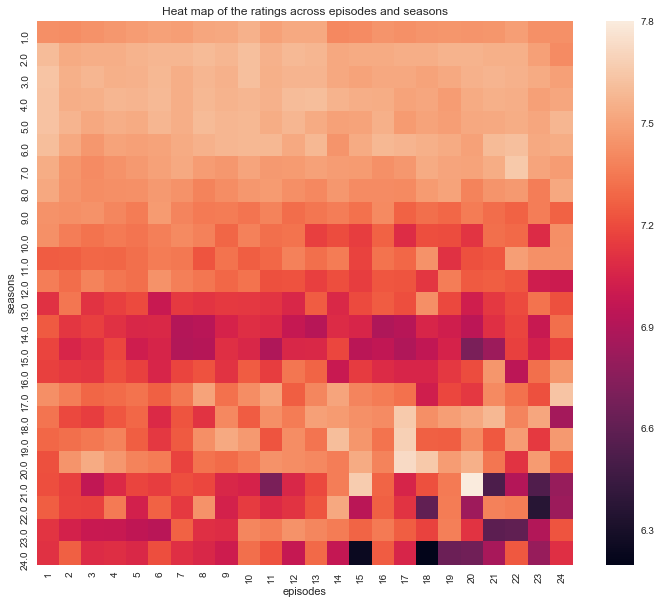

In [320]:
matplotlib.rcParams['figure.figsize'] = (12,10)
plotHeatMap()

Here we see that there is no real episodic differences in the ratings but only a little bit of variance expcept when it comes to the 20+  seasons that the final episodes start to get worse.

While on the Seasons side it averages very good on all episodes under 10 seasons but then gets derviates low and high to the end on of the Show.

Can we tell how long a series will go from the first season's ratings?

In [321]:
og = matplotlib.rcParams['figure.figsize']

In [322]:
seasonal = [myEpisodesRated.copy().loc[myEpisodesRated.parentTconst.isin(mySeasons.loc[mySeasons.seasonNumber == i].parentTconst)] for i in range(1,10)]
def plot_episodicbins(axs, df,s=0,axis=-1,bins=6,title_="", ):
    df = df.copy()
    df['episodeNumber'] = pd.to_numeric(df.episodeNumber,errors='coerce')
    epiBins = [*np.array_split(range(1,25), bins)]
    x_axis = [str(min(a))+'-'+str(max(a)) for a in epiBins]
    if s>0 : df= df[df.seasonNumber==s]
    gen_episodic= [df[df['episodeNumber'].isin(i)].averageRating for i in epiBins] 
    if axis != -1 : ax = sns.lvplot(data=gen_episodic, ax=axs[axis], scale="linear", palette="mako") 
    else : ax = sns.lvplot(data=gen_episodic, scale="linear", palette="husl")
    ax.set_xticklabels(x_axis)
    ax.set(xlabel="episodes",ylabel="rating",title=title_)

def plot3episodiclv():
    matplotlib.rcParams['figure.figsize'] = (15,7)
    sns.set_style('darkgrid', {'axes.grid' : True})
    fig, axs = plt.subplots(ncols=3)
    plot_episodicbins(axs, seasonal[0],1,0,title_="Shows with only 1 season")
    plot_episodicbins(axs, seasonal[2],1,1,title_="Shows that goes for 3 seasons")
    plot_episodicbins(axs, seasonal[5],1,2,title_="Shows that goes for 6 seasons")

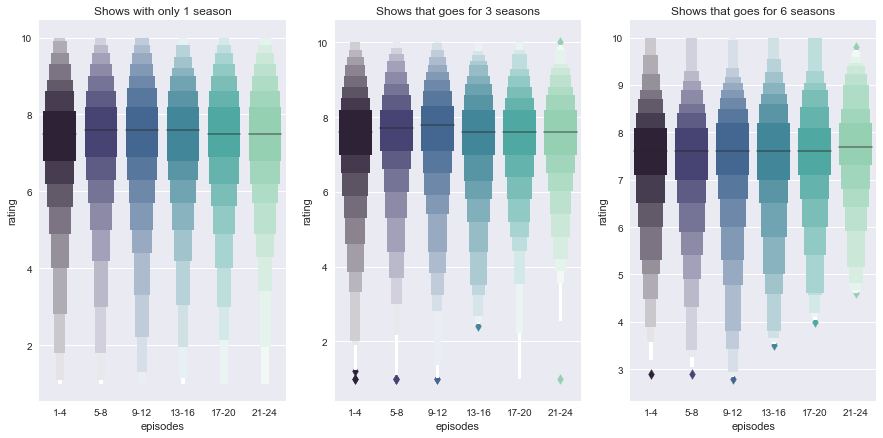

In [323]:
plot3episodiclv()

We can clearly see a trend here as the final episodes from the longer Shows have a much more focused distribution having a minimum of 5/10 while for the first all the episodes tend to be spread out across the ratings.

## Cast & Crew

In [3]:
principals_dtype = {
    'tconst': str,
    'principalCast': object
}

principals = pd.read_csv('./title.principals.tsv.gz', sep='\t', header=0, dtype=principals_dtype)

basics_dtype = {
    'tconst': str,
    'titleType': str,
    'primaryTitle': str,
    'originalTitle': str,
    'isAdult': int,
    'startYear': str,
    'endYear': str,
    'runtimeMinutes': object,
    'genres': str
}

basics = pd.read_csv('./title.basics.tsv.gz', sep='\t', header=0, dtype=basics_dtype)


In [5]:
ratings = ratings[['tconst', 'averageRating']]

actors = principals[principals['category'] == 'actor']
actors =  actors[['tconst', 'ordering', 'nconst']]

series  =  basics[basics['titleType'] == 'tvSeries']
series = series[['tconst']]

In [15]:
data = pd.merge(series, pd.merge(ratings, actors), how='inner')
data['popularity'] = pd.Series(np.zeros(data.shape[0]))
data['seriesAverageRating'] = pd.Series(np.zeros(data.shape[0]))


actorsDict = data['nconst'].value_counts().to_dict()

sumAverageRatingDict = {}

data = data.sort_values(by=['nconst'])

# iterate over dataframe "data" and fill dictionary "sumAverageRatingDict" with sum of average rating of series with this actor
for i, line in data.iterrows():
    value = line['nconst']
    if value in sumAverageRatingDict:
        rating = sumAverageRatingDict[value]
        sumAverageRatingDict[value] = rating + line['averageRating']
    else:
        sumAverageRatingDict[value] = line['averageRating']

# fill the new columns of the dataset
def fillDataset(data, actorsDict, ratingDict):
    for i, line in data.iterrows():
        value = line['nconst']
        data.set_value(i, 'popularity', actorsDict[value])
        ave = ratingDict[value] / actorsDict[value]
        data.set_value(i, 'seriesAverageRating', ave)
        
fillDataset(data, actorsDict, sumAverageRatingDict)

def plotPopular():
    data.plot(x='seriesAverageRating', y='popularity', style='o', title="Popularity of Cast/Crew vs average rating")
    plt.show()

/home/ervin/Documents/Uni/Sem02/venv/lib/python3.5/site-packages/ipykernel_launcher.py:25: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/ervin/Documents/Uni/Sem02/venv/lib/python3.5/site-packages/ipykernel_launcher.py:27: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


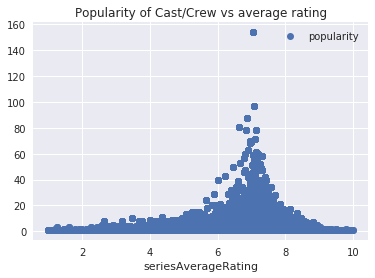

In [16]:
plotPopular()

This plot shows the more popular Cast or crew members tend to have an average rating of ~7, this means that they 
don't necessarily guarantee the best rating but they can at least get a good rating on average.

## Conclusion 

#### Some interesting features were found though more in depth work is needed to perfect their value.

#### The ratings alone aren't enough for analysis as they seem to be very similar.
Ratings don't appear to relevant when it comes to TV series, perhaps because TV series are not critically rated due to their continuity, so we end up with the same distribution for different parameters.

#### Problems with adding viewership data
Almost if not all Data is held by the Nielsen Group (One of the Data Giants ... Silo?) where payments are required to get it but still there was no clear path to getting the data.
2nd option would be to scrape wikipedia or other TV websites but that might be illegal and needs some extra work to get into data wrangling and so on.

#### Most of the data is distributed similarly hence not alot of options for plots


## End 